## Set up paths and imports

In [1]:
import os

import torch
from torchvision import transforms
import matplotlib.pyplot as plt

if not os.path.exists("./notebooks"):
    %cd ..

import src.model
from PIL import Image
from src.data_processing import load_mean_std
from src.config import DATASET_DIR
from src.dataset_analysis import plot_spectrogram
from src.training import model_predictions
from src.dataset import prepare_dataset_loaders


/home/borys/studia/ml/iml/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/borys/studia/ml/iml


## Load Model and Dataset

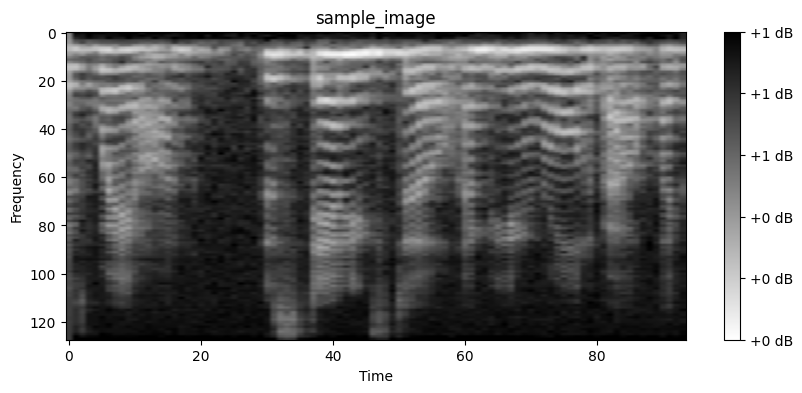

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

name = "OriginalSizeCNN-HE-RELU"
model = src.model.OriginalSizeCNN()
model_path = f"./models/{name}.pth"
model.load_state_dict(torch.load(model_path, weights_only=True))


mean, std = load_mean_std(f"{DATASET_DIR}/scaling_params.json")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

image_path = "datasets/test/f8_script1_ipad_office1_25_clip.png"
#image_path ="datasets/val/f1_script2_ipad_balcony1_1_clip.png"
sample_image = Image.open(image_path).convert("L")
sample_image = transform(sample_image)
plot_spectrogram(plt.imread(image_path), "sample_image")


#sample_image = test_loader.dataset[0][0]


## Get feture map for first Convolutional Layer

In [3]:
c1_layer = src.model.ModelWithLayerOutput(model,"conv1")
c1_layer.device = device
c1_feature_map = c1_layer(sample_image).detach().numpy()

## Visualize feature map

In [4]:
def plot_feature_map(feature_map, max_grid):
    
    fig, ax = plt.subplots(max_grid, max_grid, figsize=(7,7))
    channel_idx = 0
    
    for i in range(max_grid):
        for j in range(max_grid):
            ax[i][j].imshow(feature_map[channel_idx,:,:])
            ax[i][j].axis('off')
            
            channel_idx += 1
            
    fig.suptitle(f'Feature Map - Displaying {max_grid**2} of {feature_map.shape[0]} Channels')
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

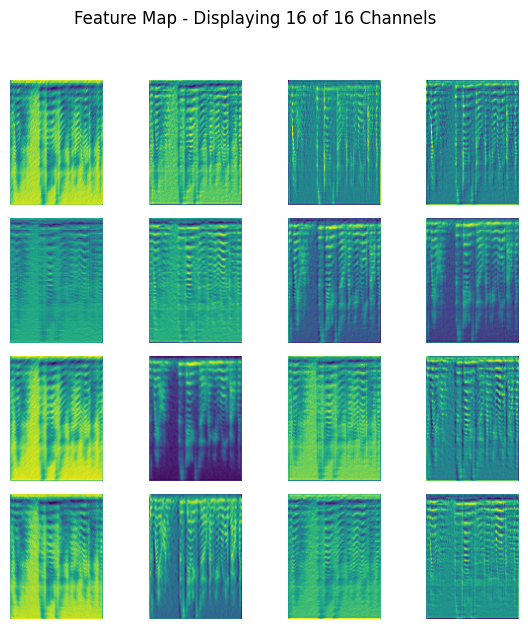

In [5]:
plot_feature_map(c1_feature_map, 4)

## Feature maps from seconds layer

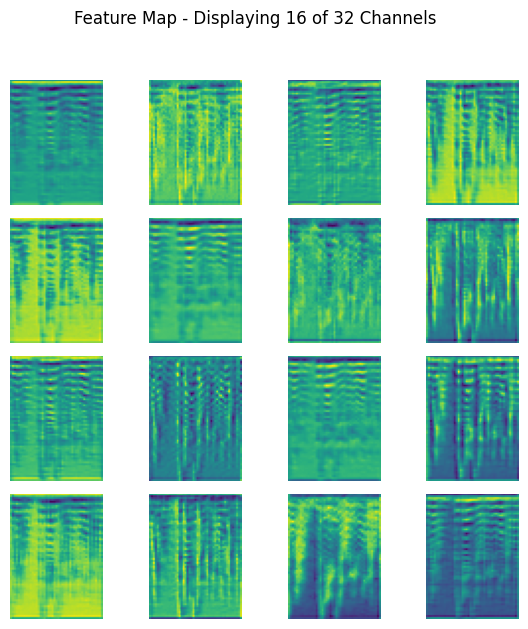

In [6]:
c2_layer = src.model.ModelWithLayerOutput(model,"conv2")
c2_layer.device = device
c2_feature_map = c2_layer(sample_image).detach().numpy()
plot_feature_map(c2_feature_map, 4)

## Compare feature maps from third layer

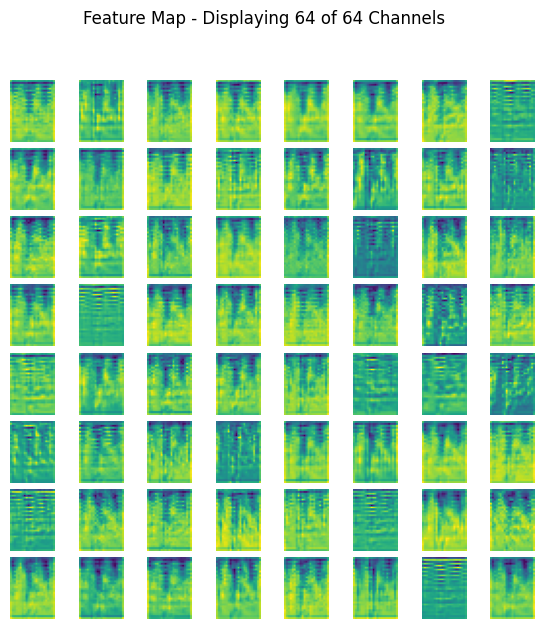

In [7]:
c3_layer = src.model.ModelWithLayerOutput(model,"conv3")
c3_layer.device = device
c3_feature_map = c3_layer(sample_image).detach().numpy()
plot_feature_map(c3_feature_map, 8)

## Similarity Search

Now that we understand how to extract semantically meaningful features with a pretrained CNN, we can explore how to use those features for the purpose of search in a scalable manner. Facebook AI Similarity Search (FAISS) is a highly optimized library that allows us to do just that - compare a query record (e.g. feature vector) against a stored database of other feature vectors to retrive those that are most similar. There are various metrics used for calculating "similarity" of two vectors, but at its simplest, similar vectors are defined as those that are nearby in Euclidean space. For more info on FAISS, check out this article.

To demonstrate FAISS in action, we'll first get feature maps from both convolution layer outputs above (block1_conv1, block5_conv3) for every image in the ICONIC200 dataset. We'll create and add all vectors from each feature map into their own FAISS index, and use those indicies for searching images against all others. Finally, we'll plot comparative similarity search results using the two feature maps for a given input image.

In [11]:
batch_size = 4 
_, _, test_loader = prepare_dataset_loaders(transform, batch_size)
c3_layer.device = "cpu"
c3_layer = c3_layer.to("cpu")
feautre_maps = model_predictions(c1_layer, test_loader)





OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 5.92 GiB of which 30.12 MiB is free. Including non-PyTorch memory, this process has 5.69 GiB memory in use. Of the allocated memory 5.61 GiB is allocated by PyTorch, and 3.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)